In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

# Our libraries
from train import train_model
from model_utils import *
from predict_utils import *
from vis_utils import *

# some initial setup
np.set_printoptions(precision=2)
use_gpu = torch.cuda.is_available()
np.random.seed(1234)

# spiliting data using tensorflow

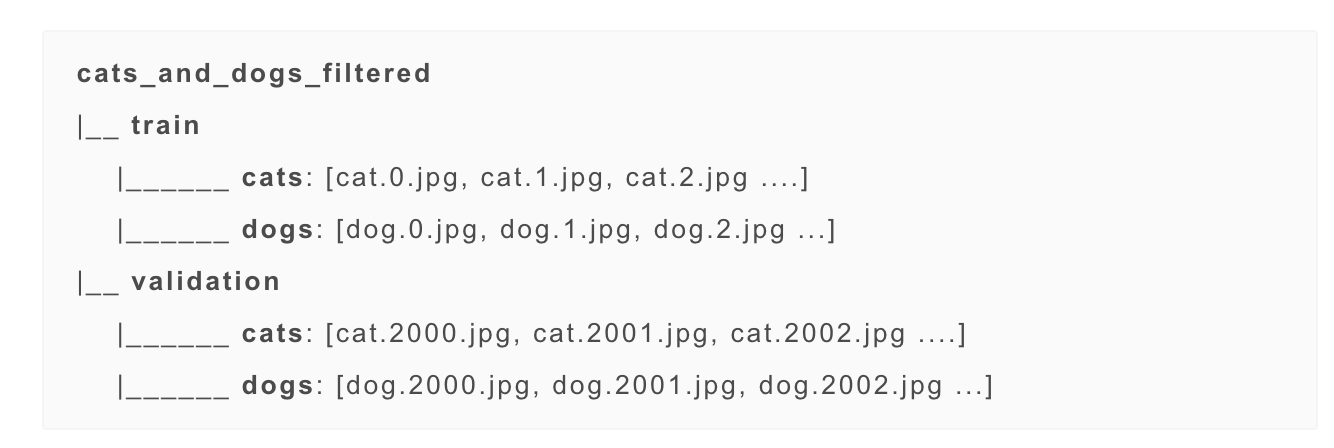

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

In [4]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [5]:
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

In [6]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [7]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [8]:
os.listdir(train_dir)

['dogs', 'cats']

In [9]:
os.listdir(validation_dir)

['dogs', 'cats']

In [10]:
trn_fms = glob.glob(f'{train_dir}/*/*.jpg')
trn_fms[:4]

['/Users/mahrokh/.keras/datasets/cats_and_dogs_filtered/train/dogs/dog.775.jpg',
 '/Users/mahrokh/.keras/datasets/cats_and_dogs_filtered/train/dogs/dog.761.jpg',
 '/Users/mahrokh/.keras/datasets/cats_and_dogs_filtered/train/dogs/dog.991.jpg',
 '/Users/mahrokh/.keras/datasets/cats_and_dogs_filtered/train/dogs/dog.749.jpg']

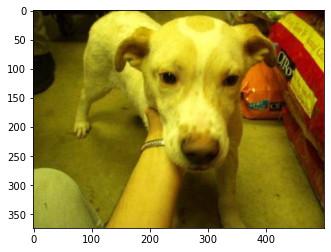

In [11]:
img = plt.imread(trn_fms[4])
plt.imshow(img);

# - Datasets
### - transforms

In [12]:
train_ds = datasets.ImageFolder(train_dir)

In [13]:
train_ds.class_to_idx

{'cats': 0, 'dogs': 1}

In [14]:
 train_ds.root

'/Users/mahrokh/.keras/datasets/cats_and_dogs_filtered/train'

### Datasets ---> transforms

In [15]:
sz =224
batch_size = 16
tfms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225] )
])

train_ds = datasets.ImageFolder(train_dir, transform=tfms)
valid_ds = datasets.ImageFolder(validation_dir, transform=tfms)

In [16]:
len(train_ds), len(valid_ds)

(2000, 1000)

# Dataloader

In [17]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=8)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True, num_workers=8)

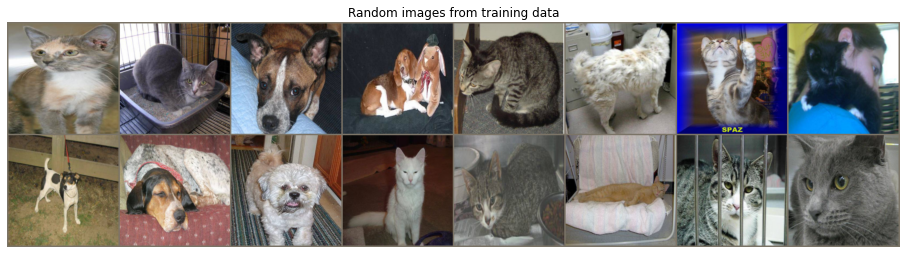

In [18]:
inputs, targets = next(iter(train_dl))
out = torchvision.utils.make_grid(inputs, padding=3)
plt.figure(figsize=(16, 12))
imshow(out, title='Random images from training data')

In [19]:
??imshow

# Model: CNN

In [26]:
 class SimpleCNN(nn.Module):
        
        def __init__(self):
            super(SimpleCNN, self).__init__()
            
            self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2), 
            nn.BatchNorm2d(16), 
            nn.ReLU(),
            nn.MaxPool2d(2))
            
            self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2), 
            nn.BatchNorm2d(32), 
            nn.ReLU(),
            nn.MaxPool2d(2))
            
            self.fc = nn.Linear(56 * 56 * 32, 2)
            
        def forward(self, x):
            out = self.conv1(x)
            out = self.conv2(out)
            out = out.View(out.size(0), -1)
            out = self.fc(out)
            return out    

In [28]:
model = SimpleCNN()

if use_gpu:
    model = model.cuda()

# Loss Function

In [29]:
criterian = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr= 0.01, momentum=0.9)

# Train

In [ ]:
num_epochs = 5
losses = []

for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_dl):
        inputs = to_var(inputs)
        targets = to_var(targets)
        
        # forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # loss 
        loss = criterian(outputs, targets)
        loss += [loss.data[0]]
        # backward pass
        loss.backward()
        
        # update parameters
        optimizer.step
        
        # report
        if (i + 1) % 50 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_ds) // batch_size, loss.data[0]))